# Coding Challenge
## Image Median Filter Parallelization

### Description of the Challenge
Local median filter is used for smoothing images and noise reduction. The degree of smoothing is determined by the kernel size which can be 2D or 3D. Applying 3D median filter to large 3D images (eg. 2000x2000x2000 voxels) is challenging because the images often do not fit in the memory and single-threaded execution of the filter is inefficient and too slow.

## Task 1
### Assignment
Create a 3D synthetic image and split it into subvolumes and apply median filter (like `skimage.filters.median`) to each subvolume in parallel. The output needs to be a 3D array with the same size as the original 3D image.

### Solution

#### Generation of synthetic images
For this assignment I could have created a dataset that contains only random noise, but it helpful to see some sort of a structure to verify that the filter actually does smoothing in the intended way. I downloaded the standard [scikit-image `cells3d` dataset](https://gitlab.com/scikit-image/data/-/raw/master/cells3d.tif) and I am going to create artificial datasets based on it. They will be of several differnt sizes to run the benchmark tests.

In [12]:
# Imports
%pylab inline

from skimage.io import imread
from skimage.filters import median
from skimage.morphology import cube

import pandas as pd

import os
from time import time

# I'll use dask and napari later but importing everything in one place
from dask.distributed import Client
from dask.array.image import imread as imread_dask
from dask_image.ndfilters import median_filter as median_dask
import dask
import numpy as np
import napari
import zarr

Populating the interactive namespace from numpy and matplotlib


C:\Users\rkiselev\Anaconda3\envs\fret\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['time', 'median', 'imread', 'axes', 'size']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
print(imread("cells3d.tif").shape)

(60, 2, 256, 256)


The order of the dataset axes is `ZSXY` where `S` are two spectral channels. I'm interested only in one of them.

In [75]:
def middle(stack):
    """ Extracts middle layer from an image stack. We assume Z axis is the fist one. """
    return stack[stack.shape[0]//2]

def middle_vert(stack):
    """ Extracts middle layer from an image stack in a vertical plane"""
    return stack[:, stack.shape[1]//2, :]

In [77]:
img = imread("cells3d.tif")[:, 1, :, :]

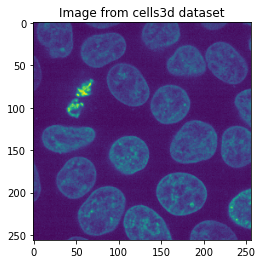

In [37]:
imshow(middle(img)); title("Image from `cells3d` dataset");

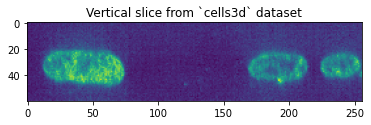

In [78]:
imshow(middle_vert(img)); title("Vertical slice from `cells3d` dataset");

In [4]:
def create_image(scale = 1, SNR = 10, readout_noise = 2):
    """
    Create an artificial dataset based on `cells3d` with given size and noise levels.
    The original image is padded with it's own edge values to create signal in the areas
    around it. Then we create a simulated shot noise-limited image and add camera noise
    on top of it.
     
    Arguments
    ---------
    scale -- size of the new dataset relative to cells3d (about 4M voxels). Value of 2 means
             twice along each axis, or 8x more voxels
    SNR -- signal to noise ratio of the simulated image (shot noise model)
    readout_noise -- level of the simulated camera noise (Gaussian model)
    
    Returns
    -------
    3d numpy array
    """
    assert scale >= 1
    src = imread("cells3d.tif")[:, 1, :, :]
    
    # Pad original image with its edge values
    z, x, y = src.shape
    pad = (
        int(0.5 * z * (scale - 1)),
        int(0.5 * x * (scale - 1)),
        int(0.5 * y * (scale - 1))
    )
    pad = [_ for _ in zip(pad, pad)]
    img = np.pad(src, pad, mode='edge')

    # Normalise image to [0,1] range
    img = (img - np.min(img))/np.ptp(img)
    
    # Create a simulated image with shot noise. SNR is sqrt(N), where N is the expected number of photons
    img = np.random.poisson(img * int(SNR**2))
    
    # Add camera bias and thermal noise and return the dataset
    return img + np.random.normal(loc=10, scale=readout_noise, size=img.shape).astype('int32')

Let's compare the original image to noisy ones

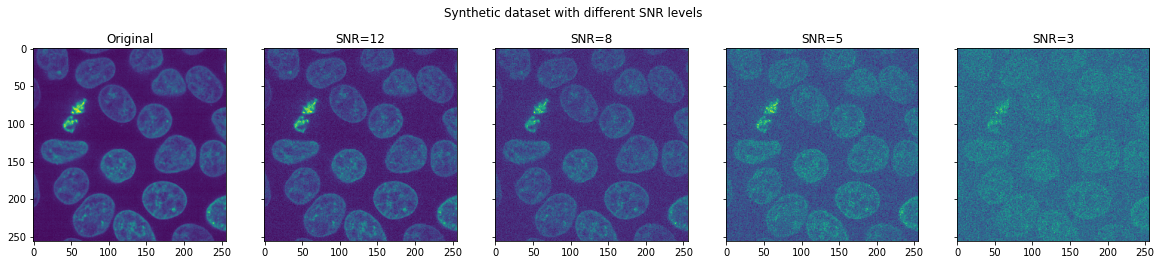

In [39]:
SNR_levels = [12, 8, 5, 3]
fig, axes = plt.subplots(1, len(SNR_levels) + 1, figsize = (20, 4), sharey = True)
fig.suptitle("Synthetic dataset with different SNR levels")
axes[0].imshow(middle(img))
axes[0].set_title("Original")
for i, SNR in enumerate(SNR_levels):
    axes[i+1].imshow(middle(create_image(scale=1, SNR=SNR)))
    axes[i+1].set_title(f"SNR={SNR}")

For all further tests I'm going to use `SNR = 8` as it is quite noisy but still has a clearly visible pattern.

Figure below compares datasets of original size and bigger ones.

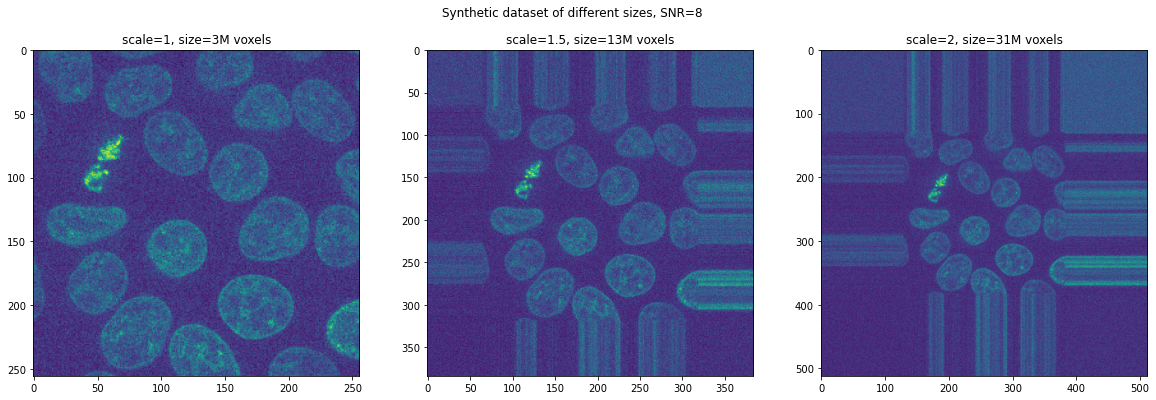

In [22]:
scales = [1, 1.5, 2]
SNR = 8

fig, axes = plt.subplots(1, len(scales), figsize = (20, 6))
fig.suptitle(f"Synthetic dataset of different sizes, SNR={SNR}")
for i, scale in enumerate(scales):
    d = create_image(scale=scale, SNR=SNR)
    size = int(np.prod(d.shape) / 1e6)
    axes[i].imshow(middle(d))
    axes[i].set_title(f"scale={scale}, size={size}M voxels")

Next, I'm going to generate my test datasets of different sizes and save them locally as Zarr arrays. First, I need to define some helper functions.

In [7]:
def stopwatch(func):
    """ Benchmarking python decorator. Returns execution time, result, and name of the decorated function. """
    def wrapper(*arg, **kw):
        t1 = time()
        res = func(*arg, **kw) # we expect `res` to be a numpy array
        t2 = time()
        size = np.prod(res.shape) // 1_000_000  # image size in mega voxels
        return dict(name=func.__name__, time=(t2 - t1), size=size), res
    return wrapper

In [8]:
@stopwatch
def save_dataset(scale, path="dataset"):
    """ Create a new synthetic image and save it as Zarr. """
    d = create_image(scale=scale, SNR=SNR)
    zarr.save(f"{path}/{scale}.zarr", d)
    return d

In [9]:
def plot_benchmark(benchmark_data, title="", xlabel="Image size, Mvoxel", ylabel="time, s", **kwargs):
    """ Plot and pretty print benchmarking data """
    df = pd.DataFrame.from_dict(benchmark_data)
    df.plot("size", "time", title=title, xlabel=xlabel, ylabel=ylabel, **kwargs)
    return df

In [10]:
# This code saves data only if the data are not present. This cell takes couple of minutes!
scales = range(1, 8)

if not os.path.exists("dataset"):
    benchmark_data = []
    for i, scale in enumerate(scales):
        benchmark_data.append(save_dataset(scale)[0])

,name,time,size
0,save_dataset,0.479648,3
1,save_dataset,3.244375,31
2,save_dataset,10.686350,106
3,save_dataset,28.138878,251
4,save_dataset,58.615938,491
5,save_dataset,101.141983,849
6,save_dataset,173.920183,1348


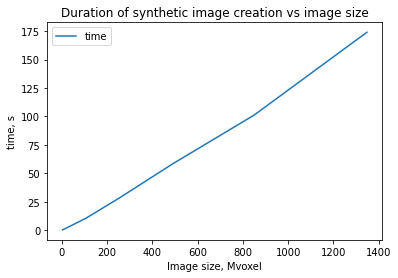

In [11]:
plot_benchmark(benchmark_data, title="Duration of synthetic image creation vs image size")

#### Image smoothing with 3D median filter

First of all, I'm going to directly apply a 3D median filter (`skimage.filters.median`) with cube-shaped kernel size of `3` to a synthetic dataset and visualize the result before and after smoothing.

In [90]:
img = zarr.load("dataset/2.zarr")
denoised = median(img, selem=cube(3))

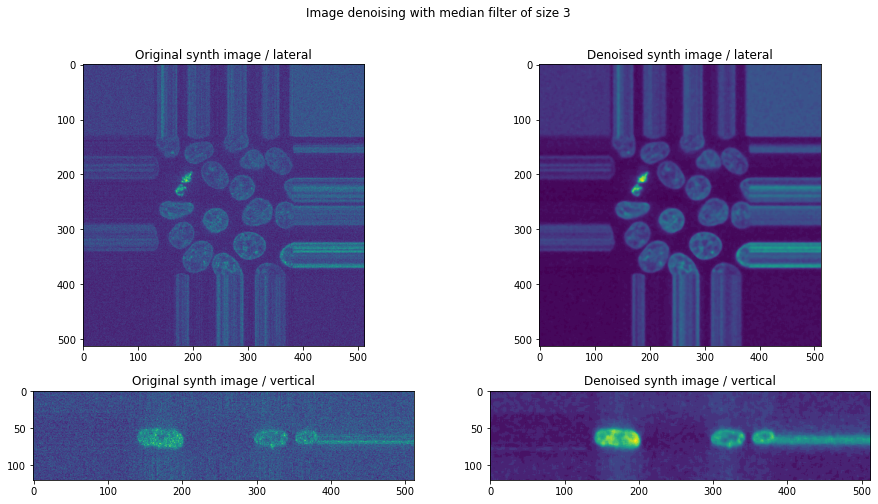

In [92]:
fig = plt.figure(figsize = (15, 8))
fig.suptitle("Image denoising with median filter of size 3")

ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

ax1.imshow(middle(img));
ax1.set_title("Original synth image / lateral");

ax2.imshow(middle_vert(img));
ax2.set_title("Original synth image / vertical");

ax3.imshow(middle(denoised));
ax3.set_title("Denoised synth image / lateral");

ax4.imshow(middle_vert(denoised));
ax4.set_title("Denoised synth image / vertical");

Now I'm going to measure how long it takes to process datasets of different sizes. **I expect to see a linear dependency between the data set size in voxels and processing time, i.e. linear time complexity _O(n)_**.

In [93]:
@stopwatch
def denoise(img, selem=cube(3)):
    """ Denoise image with a median filter """
    return median(img, selem=selem)

In [ ]:
#bm_denoise_imgsize = []
for i in range(4, 8):
    img = zarr.load(f"dataset/{i}.zarr")
    bm_denoise_imgsize.append(denoise(img)[0])

,name,time,size
0,denoise,1.010926,3
1,denoise,8.103736,31
2,denoise,31.161718,106
3,denoise,65.936116,251
4,denoise,134.409001,491


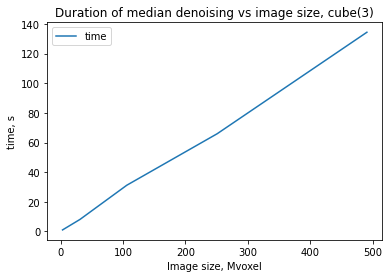

In [103]:
plot_benchmark(bm_denoise_imgsize, title="Duration of median denoising vs image size, cube(3)")

In [ ]:
1 + 4

This image has unusual dimensions, but we can look at it with napari using the following code:
```python
v = napari.Viewer()
v.add_image(img)
```
We extract the second spectral channel like this